In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

house = pd.read_csv("https://raw.githubusercontent.com/icaromisquita/archives/main/housing-classification-iter3.csv")
house.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc


In [2]:
house.shape

(1460, 16)

###Removing the "Expensive" column from the Dataframe as it is the variable we want to predict (y value) 

In [3]:
y= house["Expensive"]
X = house
X = X.drop(columns="Expensive")

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
X.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
MSZoning          0
Condition1        0
Heating           0
Street            0
CentralAir        0
Foundation        0
dtype: int64

###Creating the "numeric pipe" and the "categoric pipe"

In [5]:
# import
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns
X_num_columns = X.select_dtypes(include="number").copy().columns

#Setting the imputers, Scaler 
imputer = SimpleImputer()
scaler = StandardScaler()

# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(imputer,
                     scaler)
                     

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder()
)

####Using a pipeline with 2 branches 

In [6]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num_columns),
        ("cat_pipe", categoric_pipe, X_cat_columns),
    ]
)

###Creating the full_pipeline (preprocessor + Decision Tree)

In [7]:
full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

###We can then fit this full_pipeline to the data:

Note: notice that we did not fit the preprocessor before —we only fit the pipeline once it has been full assembled.

In [8]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N_A',
                                                                                 strategy='constan

###Doing them a prediction

In [9]:
full_pipeline.predict(X_train)

array([1, 0, 1, ..., 1, 0, 0])

####A code to ignore the errors, when using the GridSearch validation

In [10]:
import warnings
warnings.filterwarnings('ignore')

##Using the new Pipeline with branches to train a DecisionTree with GridSearch cross validation.

In [11]:
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())
param_grid = {
    "columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "columntransformer__num_pipe__standardscaler__with_mean":[True, False],
    "columntransformer__num_pipe__standardscaler__with_std":[True, False], 
    "decisiontreeclassifier__max_depth": range(2, 14),
    "decisiontreeclassifier__min_samples_leaf": range(2,20),
    "decisiontreeclassifier__criterion":["gini", "entropy"]     
}


search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=10,
                      verbose=1)

search.fit(X_train, y_train)

Fitting 10 folds for each of 3456 candidates, totalling 34560 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch'],
      dtype='object')),
                                                                        ('cat_pipe...
             param_grid={'columntransformer__num_pipe__simpleimputer__strate

In [12]:
full_pipeline["decisiontreeclassifier"].get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

###Checking the Accuracy
Make predictions and check accuracy on the train set

In [13]:
from sklearn.metrics import accuracy_score

y_pred_tree_train = search.predict(X_train)

accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train
              )

0.9143835616438356

Make predictions on the test set

In [14]:
y_pred_tree_test = search.predict(X_test)

accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test
              )

0.9178082191780822

##Printing the tree

###Retrieving the column names for the "one-hot" columns

In [15]:
# selecting non-numerical columns
X_train_cat = X_train.select_dtypes(exclude="number")

# defining the imputer to use "N_A" as replacement value
cat_imputer = SimpleImputer(strategy="constant", 
                            fill_value="N_A")

# fitting the imputer
cat_imputer.fit(X_train_cat)

# transforming the data & keeping it as a DataFrame
X_cat_imputed = pd.DataFrame(cat_imputer.transform(X_train_cat), 
                             columns=X_train_cat.columns)
X_cat_imputed.head()

# initialize
my_onehot = OneHotEncoder(drop="first")

# fit
my_onehot.fit(X_cat_imputed)

# transform
X_cat_imputed_onehot = my_onehot.transform(X_cat_imputed)
df = pd.DataFrame.sparse.from_spmatrix(X_cat_imputed_onehot)

colnames = my_onehot.get_feature_names_out(X_cat_imputed.columns)
df.columns = colnames
df.head(3)

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,...,Heating_Grav,Heating_OthW,Heating_Wall,Street_Pave,CentralAir_Y,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


Plotting the tree

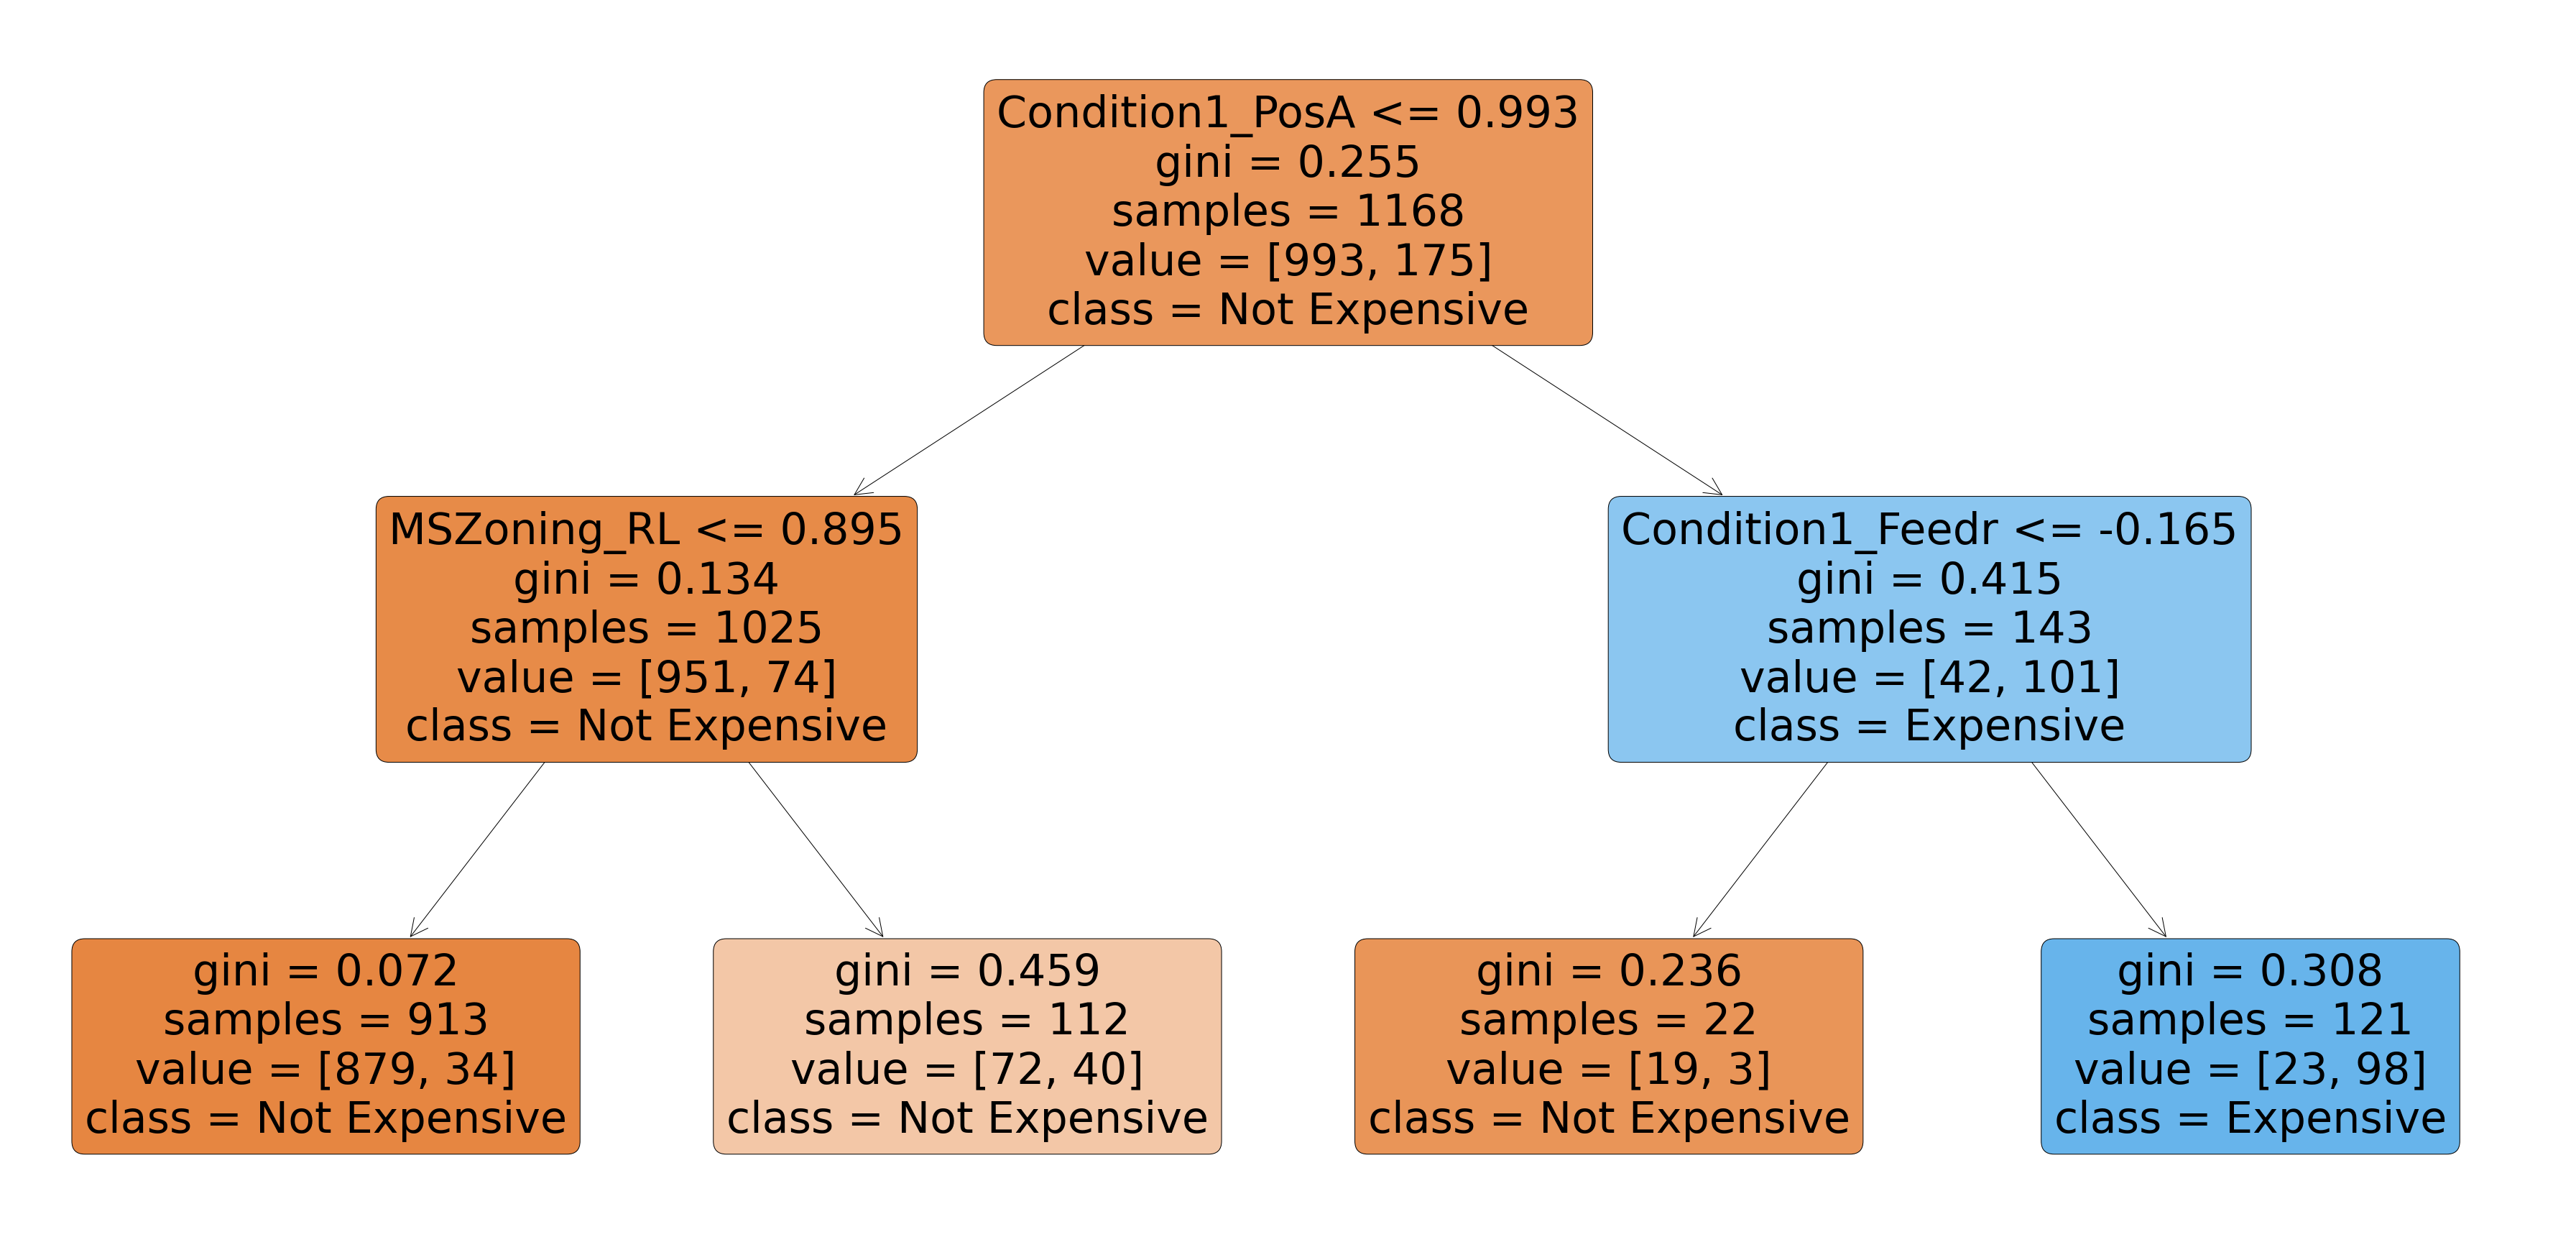

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(64, 32))
plot_tree(
    search.best_estimator_['decisiontreeclassifier'],
    filled=True, 
    rounded=True, 
    feature_names=df.columns,
    class_names=[ 'Not Expensive', 'Expensive']
    );